<a href="https://colab.research.google.com/github/Aniket2074/Airbnb_Price_Prediction/blob/main/Airbnb_Price_Prediction_InlighnX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# dataset
df = pd.read_csv('/content/New Year Sales Data.csv', encoding='latin-1')
print("Data shape:", df.shape)
df.head()

Data shape: (11251, 15)


,User_ID,Cust_name,Product_ID,Gender,Age Group,Age,Marital_Status,State,Zone,Occupation,Product_Category,Orders,Amount,Status,unnamed1
0,1002903,Sanskriti,P00125942,F,26-35,28,0,Maharashtra,Western,Healthcare,Auto,1,23952.0,NaN,NaN
1,1000732,Kartik,P00110942,F,26-35,35,1,Andhra Pradesh,Southern,Govt,Auto,3,23934.0,NaN,NaN
2,1001990,Bindu,P00118542,F,26-35,35,1,Uttar Pradesh,Central,Automobile,Auto,3,23924.0,NaN,NaN
3,1001425,Sudevi,P00237842,M,0-17,16,0,Karnataka,Southern,Construction,Auto,2,23912.0,NaN,NaN
4,1000588,Joni,P00057942,M,26-35,28,1,Gujarat,Western,Food Processing,Auto,2,23877.0,NaN,NaN


In [3]:
# Droping useless or duplicate columns
df = df.drop(columns=['Cust_name', 'Status', 'unnamed1'], errors='ignore')

# Checking missing values
print(df.isnull().sum())

# Converting column names for consistency
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Droping duplicates
df.drop_duplicates(inplace=True)

User_ID              0
Product_ID           0
Gender               0
Age Group            0
Age                  0
Marital_Status       0
State                0
Zone                 0
Occupation           0
Product_Category     0
Orders               0
Amount              12
dtype: int64


In [4]:
# Drop rows with missing Amount
df = df.dropna(subset=['Amount'])

# Define features and target
X = df.drop(columns=['Amount', 'User_ID', 'Product_ID'])
y = df['Amount']

# Split numeric and categorical columns
numeric_features = ['Age', 'Orders']
categorical_features = [col for col in X.columns if col not in numeric_features]

In [5]:
# Pipelines for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# XGBoost Regression pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42,
        n_jobs=-1
    ))
])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


In [7]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")

# Compare few predictions
result = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
result.head(10)

RMSE: 10163330.46
MAE:  2394.16
R²:   0.629


,Actual,Predicted
0,3016.0,3065.252441
1,15367.0,13272.710938
2,3779.0,3175.327637
3,15880.0,13905.682617
4,6963.0,6354.173828
5,5849.0,7330.351562
6,15996.0,11544.148438
7,15917.0,13627.747070
8,7839.0,7601.724121
9,15853.0,13437.307617


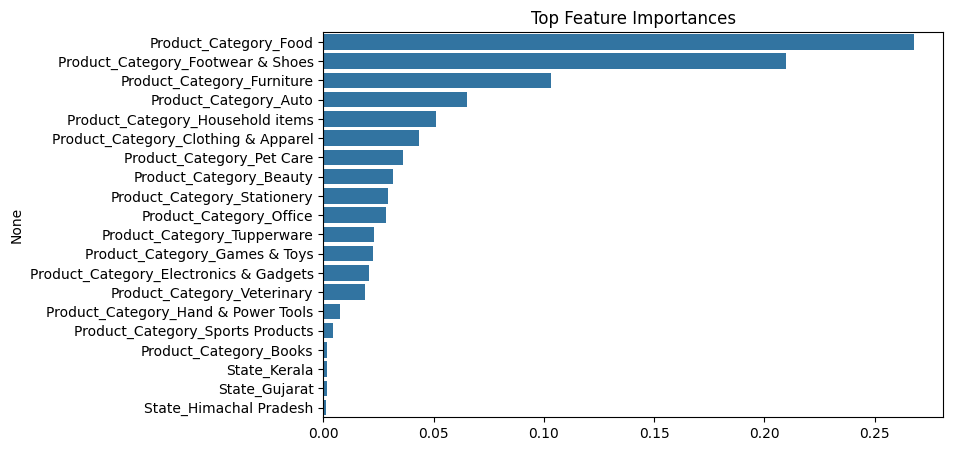

In [8]:
# Access trained XGB model
xgb_model = model.named_steps['regressor']

# Extract one-hot encoded feature names
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out(categorical_features))
all_features = numeric_features + cat_names

importances = xgb_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top Feature Importances")
plt.show()


In [9]:
import joblib
joblib.dump(model, 'sales_amount_predictor.joblib')
print("Model saved as sales_amount_predictor.joblib")


Model saved as sales_amount_predictor.joblib


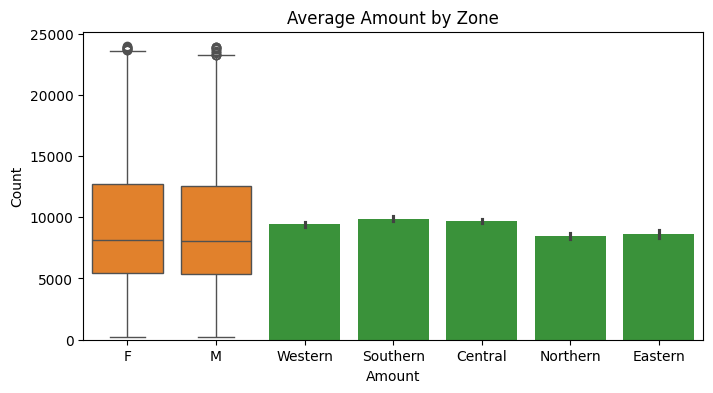

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Purchase Amounts")

sns.boxplot(x='Gender', y='Amount', data=df)
plt.title("Amount spent by Gender")

sns.barplot(x='Zone', y='Amount', data=df, estimator=np.mean)
plt.title("Average Amount by Zone")
plt.show()
